# Test `compare_venus_ctd` Module

Render figure object produced by the `nowcast.figures.publish.compare_venus_ctd` module.
Provides data for visual testing to confirm that refactoring has not adversely changed figure for web page.

Set-up and function call replicates as nearly as possible what is done in the `nowcast.workers.make_plots` worker.

In [1]:
import io
import os
from pathlib import Path

import arrow
import netCDF4 as nc
import yaml

from salishsea_tools import nc_tools

from nowcast.figures import research_VENUS
from nowcast.figures.comparison import compare_venus_ctd

In [2]:
%matplotlib inline

**NOTE**

The next cell mounts the `/results` filesystem on `skookum` and the `/ocean` filesystem locally.
It is intended for use if when this notebook is run on a laptop or other
non-Waterhole machine that has `sshfs` installed 
and mount points for `/results` and `/ocean` available in its root filesystem.

Don't execute the cell if that doesn't describe your situation.

!sshfs skookum:/results /results
!sshfs skookum:/ocean /ocean

In [3]:
config = '''
    timezone: Canada/Pacific
    
    bathymetry: /results/nowcast-sys/NEMO-forcing/grid/bathy_meter_SalishSea2.nc
    mesh_mask: /results/nowcast-sys/NEMO-forcing/grid/mesh_mask_SalishSea2.nc

    run:
        results_archive:
            nowcast: /results/SalishSea/nowcast/
            forecast: /results/SalishSea/forecast/
'''

config = yaml.load(io.StringIO(config))

In [4]:
run_date = arrow.get('2016-06-28')
run_type = 'nowcast'

dmy = run_date.format('DDMMMYY').lower()
start_day = {
    'nowcast': run_date.format('YYYYMMDD'),
    'forecast': run_date.replace(days=+1).format('YYYYMMDD'),
}
end_day = {
    'nowcast': run_date.format('YYYYMMDD'),
    'forecast': run_date.replace(days=+2).format('YYYYMMDD'),
}
ymd = run_date.format('YYYYMMDD')

results_home = Path(config['run']['results_archive'][run_type])
results_dir = results_home/dmy

In [5]:
bathy = nc.Dataset(config['bathymetry'])
mesh_mask = nc.Dataset(config['mesh_mask'])
grid_T_hr = nc.Dataset(
    str(results_dir/'SalishSea_1h_{0}_{1}_grid_T.nc'
        .format(start_day[run_type], end_day[run_type])))

1 loop, best of 1: 5.5 s per loop


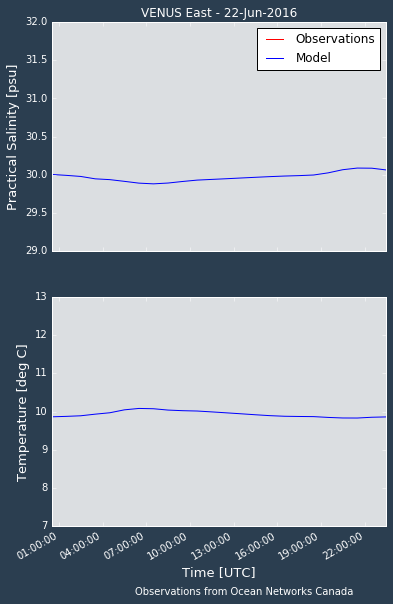

In [42]:
%%timeit -n1 -r1

# Reference rendering of figure

fig = research_VENUS.compare_VENUS(
    'East', grid_T_hr, bathy)

1 loop, best of 1: 21.1 s per loop


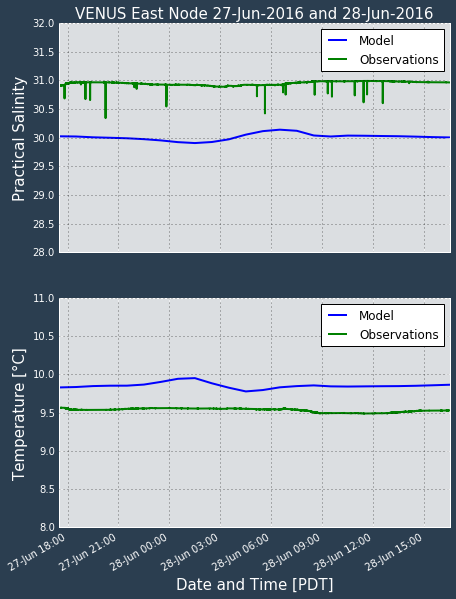

In [35]:
%%timeit -n1 -r1

# Refactored rendering of figure

from importlib import reload
from nowcast.figures import website_theme, shared
from salishsea_tools import places, data_tools
reload(compare_venus_ctd)
reload(website_theme)
reload(shared)
reload(places)
reload(data_tools)

fig = compare_venus_ctd.compare_venus_ctd(
    'East node', grid_T_hr, config['timezone'], mesh_mask,
    theme=website_theme)